## Семинар 9: "LSTM"


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset


Этот семинар посвящен реализации RNN в pyTorch


## Задание 1


Напишите свою реализацию LSTM.


<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">


In [2]:
from torch.autograd import Variable


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size

        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size))

        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size))

        self.b = nn.Parameter(torch.Tensor(self.gate_size))

        self.linear = nn.Linear(self.hidden_size, 1)

        self.init_weights()

    def init_weights(self):
        for weight in self.parameters():
            weight.data.uniform_(-0.1, 0.1)

    def forward(self, inputs, hidden=None):
        # input_size это размерность вектора измерений в момент времени t
        # т.е. ячейка не должна зависеть от того что там лежит и
        # размера батча, но там лежало n прошлых измерений
        # и возникали проблемы с размерами батчей

        # я предпочитаю batch_size иметь на первом месте
        # inputs: (batch_size, seq_len, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)

        # вроде как и ячейка lstm, раз принимает hidden
        bs = inputs.size(0)
        if hidden is None:
            h, c = (
                torch.zeros(bs, self.hidden_size),
                torch.zeros(bs, self.hidden_size),
            )
        else:
            h, c = hidden

        seq_length = inputs.size(1)
        out = Variable(
            torch.Tensor(bs, seq_length, self.hidden_size), requires_grad=False
        )

        # но в то же время имеется цикл, т.е. вроде как и RNN
        for t in range(seq_length):
            x_t = inputs[:, t, :]

            S = torch.matmul(x_t, self.W_i) + torch.matmul(h, self.W_h) + self.b

            i_1 = torch.sigmoid(S[:, : self.hidden_size])
            f_1 = torch.sigmoid(S[:, self.hidden_size : self.hidden_size * 2])
            g_1 = torch.tanh(S[:, self.hidden_size * 2 : self.hidden_size * 3])
            o_1 = torch.sigmoid(S[:, self.hidden_size * 3 :])

            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[:, t, :] = h

        # раз уже в цикле прогнали всю последовательность
        # значит возвращать hidden незачем. тогда линейный слой накинем сразу
        return self.linear(out[:, -1, :])


## Задание 2


Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.


Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line


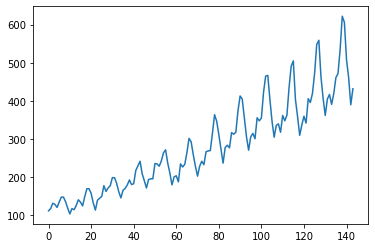

In [3]:
dataset = pandas.read_csv(
    "international-airline-passengers.csv",
    usecols=[1],
    delimiter=";",
    engine="python",
    skipfooter=3,
)
plt.plot(dataset)
plt.show()


In [4]:
# подготовливаем данные
from sklearn.preprocessing import StandardScaler

dataset = dataset.values
dataset = dataset.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))

# dataset = scaler.fit_transform(dataset)


In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
print(len(train), len(test))

train = scaler.fit_transform(train)
test = scaler.transform(test)


96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов


def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1 - look_forward):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)


In [7]:
# по идее код выше делает не очень правильно, т.к. последняя размерность
# после него становится look_back,
# т.е. ячейка lstm видит напрямую n прошлых токенов в фичах текущего токена
# а не смотрит на них через призму hidden

# чуть-чуть переписал нашедшийся у меня класс датасета для похожей задачи
class SeqToSeqDataset(Dataset):
    def __init__(
        self,
        dataframe,
        sequence_length=96,
        forecast_length=24,
        device="cpu",
    ):
        self.sequence_length = sequence_length
        self.forecast_length = forecast_length
        self.device = device

        self.data = torch.tensor(dataframe).float()

    def __len__(self):
        return self.data.shape[0] - self.sequence_length - self.forecast_length + 1

    def __getitem__(self, i):
        src_start = i
        src_end = src_start + self.sequence_length
        seq_x = self.data[src_start:src_end]

        y_start = src_end
        y_end = y_start + self.forecast_length
        seq_y = self.data[y_start:y_end] 

        return seq_x.to(self.device), seq_y.to(self.device)


In [8]:
# Пример подготовленных данных
sequence_length = 30
forecast_length = 1
# look_back = 30
# look_forward=1
# trainX, trainY = create_dataset(train, look_back, look_forward)
# testX, testY = create_dataset(test, look_back, look_forward)

torch.manual_seed(101)
batch_size = 7 

train_dataset = SeqToSeqDataset(train, sequence_length, forecast_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X, y = next(iter(train_loader))

print("Features:", X.shape, sep="\t")
print("Target:\t", y.shape, sep="\t")


# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


Features:	torch.Size([7, 30, 1])
Target:		torch.Size([7, 1, 1])


In [9]:
# для X, y при batch_size = 1 и shuffle=False имеем
# X = tensor([[[0.0259],
#          [0.0453],
#          [0.0906],
#          [0.0809],
#          [0.0550]]])
# y = tensor([[[0.1003]]])
# при этом train[:6]
# array([[0.02588999],
#        [0.04530746],
#        [0.09061491],
#        [0.08090615],
#        [0.05501619],
#        [0.10032365]], dtype=float32)
# т.е. всё идеально


In [10]:
# train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
# test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))


In [11]:
# batch_size = 1

# train_dataloader =  DataLoader(train_dataset, batch_size=batch_size)
# test_dataloader =  DataLoader(test_dataset, batch_size=batch_size)


In [12]:
hidden_size = 64
input_size = 1
lstm = LSTM(input_size, hidden_size)
optimizer = optim.Adam(lstm.parameters(), lr=1e-3)
loss_function = torch.nn.MSELoss()

for epoch in range(1, 800 + 1):
    total_loss = 0
    num_batches = len(train_loader)
    
    for X, y in train_loader:
        output = lstm.forward(X)
        
        loss = loss_function(output, y.squeeze(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        
    avg_loss = total_loss / num_batches
    if epoch % 100 == 0:
        print("train loss\t=\t", avg_loss)
        
        

train loss	=	 0.0037568986066617072
train loss	=	 0.0018175748467911036
train loss	=	 0.0013542469125241042
train loss	=	 0.0017610138922464103
train loss	=	 0.0010029298457084224
train loss	=	 0.0007115863103535957
train loss	=	 0.0007075057568727061
train loss	=	 0.0004789548122062115


In [13]:
# тут не будет первого токена теста
input = train_dataset[len(train_dataset)][0].unsqueeze(0)

outs = []
with torch.no_grad():
    for t in range(test_size):
        out = lstm.forward(input)
        out = out[0,0]
        
        input = input.roll(-1)
        input[0,-1,0] = out
        
        outs.append(out.item())
        

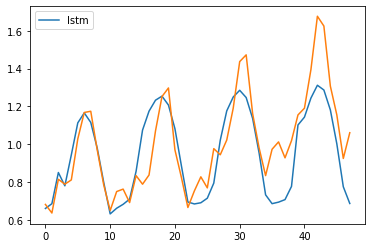

In [14]:
plt.plot(outs[1:], label="lstm")
plt.plot(test[:, 0])
plt.legend()
plt.show()


## Задание 3

Поучаствуйте в соревновании https://www.kaggle.com/t/db8f882eee2b4fbd9936a8c51b62245c

Для зачета задания нужно получить значение MAPE меньше 0.2

До 3 декабря 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.

Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)


#### Feedback (опционально)


Здесь вы можете оставить список опечаток из лекции или семинара:


Здесь вы можете оставить комментарии по лекции или семинару:
